## 下面要分析数据，重点就是作图，图多不惊人，惊人死不休
* SDFcost_Franka/SDFcost_FrankaScatter_bound0.03.csv ： lap_count = 10 , 障碍物左右移动，移动边界定为 -0.30 -- 0.30
* SDFcost_Franka/SDFcost_FrankaScatter_bound0.04.csv ： 障碍物左右移动，移动边界定为 -0.40 -- 0.40
* SDFcost_Franka/SDFcost_FrankaScatter_updown.csv : 障碍物上下移动

-  需要注意的是，这里的数据与2D实验不同，由于franka实验过分的偶然性，这里的数据是多组实验后计算的均值，所以需要在数据预处理部分做一些工作。

## SDFcost_Franka/SDFcost_FrankaScatter_bound0.03.csv 

In [1]:
## 首先对文件数据预处理 清洗出 非数字开头的注释行
import pandas as pd
from io import StringIO

# 读取整个文件到一个字符串
with open('SDFcost_FrankaScatter_bound0.03.csv', 'r') as file:
    data = file.readlines()

# 过滤出数字开头的行，但保留首行（列标题）
data = [data[0]] + [line for line in data[1:] if line[0].isdigit()]

# 将清洗后的数据列表转换成一个字符串
clean_data = ''.join(data)
# 使用StringIO对象来使用pd.read_csv
df = pd.read_csv(StringIO(clean_data))


## 数据还是过少
1. 必须要计算均值，避免极端数值的影响
2. PM相比之下更少

In [2]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
from io import StringIO

def plot_scatter_from_csv(file_name):
    # 读取整个文件到一个字符串, 并处理可能不规范的以逗号结尾的行
    with open(file_name, 'r') as file:
        data = [line.rstrip(',\n') + '\n' for line in file.readlines()]

    # 过滤出数字开头的行，但保留首行（列标题）
    data = [data[0]] + [line for line in data[1:] if line[0].isdigit()]

    # 将清洗后的数据列表转换成一个字符串
    clean_data = ''.join(data)
    # 使用StringIO对象来使用pd.read_csv
    df_origin = pd.read_csv(StringIO(clean_data))
    # 添加一列，用于记录每行数据oneOpt小数点保留的位数
    df_origin['oneOpt_decimal_places'] = df_origin['oneOpt'].apply(lambda x: len(str(x).split('.')[1]) if '.' in str(x) else 0)

    # 根据oneOpt小数点保留的位数分为两类
    long_origin_data = df_origin[df_origin['oneOpt_decimal_places'] > 3]
    short_mean_data = df_origin[df_origin['oneOpt_decimal_places'] <= 3]

    # 创建一个1行2列的子图布局
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Collision Count vs opt_step_count', 'Crash Rate vs Path Length'))

    # 第一个散点图的设置
    fig.add_trace(
        go.Scatter(
            x=long_origin_data['collision_count'], 
            y=long_origin_data['opt_step_count'],
            mode='markers',
            hovertemplate="Collision Count: %{x}<br>opt_step_count: %{y}<br>" +
                          "goal_w: %{customdata[0]}<br>" +
                          "coll_w: %{customdata[1]}<extra></extra>",
            customdata=long_origin_data[['goal_w', 'collision_w']],
            marker=dict(color='red'),  # 设置颜色为红色
            name='long_origin_data Collision/opt_step_count'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=short_mean_data['collision_count'], 
            y=short_mean_data['opt_step_count'],
            mode='markers',
            hovertemplate="Collision Count: %{x}<br>opt_step_count: %{y}<br>" +
                          "goal_w: %{customdata[0]}<br>" +
                          "coll_w: %{customdata[1]}<extra></extra>",
            customdata=short_mean_data[['goal_w', 'collision_w']],
            marker=dict(color='blue'),  # 设置颜色为蓝色
            name='short_mean_data Collision/opt_step_count'
        ),
        row=1, col=1
    )


    # 第一个散点图的X、Y轴范围
    fig.update_xaxes(title_text="Collision Count", row=1, col=1)
    fig.update_yaxes(title_text="opt_step_count",  row=1, col=1)

    # 第二个散点图的设置

    fig.add_trace(
        go.Scatter(
            x=long_origin_data['crash_rate'], 
            y=long_origin_data['joints_path_length'],
            mode='markers',
            hovertemplate="Crash Rate: %{x}<br>joints_path_length: %{y}<br>" +
                          "goal_w: %{customdata[0]}<br>" +
                          "coll_w: %{customdata[1]}<extra></extra>",
            customdata=long_origin_data[['goal_w', 'collision_w']],
            marker=dict(color='orange'),  # 设置颜色为橙色
            name='long_origin_data Crash Rate/joints_path_length'
        ),
        row=1, col=2
    )

    fig.add_trace(
        go.Scatter(
            x=short_mean_data['crash_rate'], 
            y=short_mean_data['joints_path_length'],
            mode='markers',
            hovertemplate="Crash Rate: %{x}<br>joints_path_length: %{y}<br>" +
                          "goal_w: %{customdata[0]}<br>" +
                          "coll_w: %{customdata[1]}<extra></extra>",
            customdata=short_mean_data[['goal_w', 'collision_w']],
            marker=dict(color='green'),  # 设置颜色为绿色
            name='short_mean_data Crash Rate/joints_path_length'
        ),
        row=1, col=2
    )

    # 第二个散点图的X、Y轴范围
    fig.update_xaxes(title_text="Crash Rate", row=1, col=2)
    fig.update_yaxes(title_text="Path Length", row=1, col=2)

    # 更新整体布局设置
    fig.update_layout(
        title_text="Combined Subplots with Custom axis ranges for " + file_name
    )

    # 显示整个布局
    fig.show()

    # 如果你想保存成图片，需要安装kaleido：pip install -U kaleido
    # 并且可以使用：
    # fig.write_image("combined_plots.png")


In [3]:
# 调用函数并输出图片
plot_scatter_from_csv('SDFcost_FrankaScatter_bound0.03.csv')

# 调用函数并输出图片
plot_scatter_from_csv('SDFcost_FrankaPMScatter_bound0.03.csv')


In [4]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
from io import StringIO

from scipy.__config__ import show

def plot_scatter_from_csv(file_names, specific_weights):
    # Create a subplot layout with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=2)
                #  subplot_titles=('Collision Count vs opt_step_count', 'Crash Rate vs Path Length'))

    colors = ['red', 'blue', 'orange', 'green']  # Define colors for each file

    # Parse specific_weights dictionary
    goal_w = specific_weights.get('goal_w')
    coll_w = specific_weights.get('coll_w')
    if goal_w is None or coll_w is None:
        print("Invalid specific weights provided!")
        return

    for idx, file_name in enumerate(file_names):
        # Read the entire file into a string and handle lines possibly ending with commas
        with open(file_name, 'r') as file:
            data = [line.rstrip(',\n') + '\n' for line in file.readlines()]

        # Filter out lines starting with numbers but keep the first line (column headers)
        data = [data[0]] + [line for line in data[1:] if line[0].isdigit()]

        # Convert the cleaned data list into a string
        clean_data = ''.join(data)
        # Use StringIO object to use pd.read_csv
        df_origin = pd.read_csv(StringIO(clean_data))
        # Add a column to record the number of decimal places for each row of data in oneOpt
        df_origin['oneOpt_decimal_places'] = df_origin['oneOpt'].apply(lambda x: len(str(x).split('.')[1]) if '.' in str(x) else 0)

        # Divide the data into two categories based on the number of decimal places in oneOpt
        long_origin_data = df_origin[df_origin['oneOpt_decimal_places'] > 3]
        short_mean_data = df_origin[df_origin['oneOpt_decimal_places'] <= 3]
 
        # Add scatter plots for each file
        # fig.add_trace(
        #     go.Scatter(
        #         x=long_origin_data['collision_count'], 
        #         y=long_origin_data['opt_step_count'],
        #         mode='markers',
        #         hovertemplate="Collision Count: %{x}<br>opt_step_count: %{y}<br>" +
        #                       "goal_w: %{customdata[0]}<br>" +
        #                       "coll_w: %{customdata[1]}<extra></extra>",
        #         customdata=long_origin_data[['goal_w', 'collision_w']],
        #         marker=dict(color=colors[2*idx]),  # Set color based on file index
        #         name=f'File {idx+1} Long Origin Data Collision/opt_step_count'
        #     ),
        #     row=1, col=1
        # )

        fig.add_trace(
            go.Scatter(
                x=short_mean_data['collision_count'], 
                y=short_mean_data['opt_step_count'],
                mode='markers',
                hovertemplate="Collision Count: %{x}<br>opt_step_count: %{y}<br>" +
                              "goal_w: %{customdata[0]}<br>" +
                              "coll_w: %{customdata[1]}<extra></extra>",
                customdata=short_mean_data[['goal_w', 'collision_w']],
                marker=dict(color=colors[2*idx+1]),  # Set color based on file index
                name= 'Singel_layer MPPI' if idx == 0 else 'PM MPPI'
            ),
            row=1, col=1
        )

        # fig.add_trace(
        #     go.Scatter(
        #         x=long_origin_data['crash_rate'], 
        #         y=long_origin_data['joints_path_length'],
        #         mode='markers',
        #         hovertemplate="Crash Rate: %{x}<br>joints_path_length: %{y}<br>" +
        #                       "goal_w: %{customdata[0]}<br>" +
        #                       "coll_w: %{customdata[1]}<extra></extra>",
        #         customdata=long_origin_data[['goal_w', 'collision_w']],
        #         marker=dict(color=colors[2*idx]),  # Set color based on file index
        #         name=f'File {idx+1} Long Origin Data Crash Rate/joints_path_length'
        #     ),
        #     row=1, col=2
        # )

        fig.add_trace(
            go.Scatter(
                x=short_mean_data['crash_rate'], 
                y=short_mean_data['joints_path_length'],
                mode='markers',
                hovertemplate="Crash Rate: %{x}<br>joints_path_length: %{y}<br>" +
                              "goal_w: %{customdata[0]}<br>" +
                              "coll_w: %{customdata[1]}<extra></extra>",
                customdata=short_mean_data[['goal_w', 'collision_w']],
                marker=dict(color=colors[2*idx+1]),  # Set color based on file index
                showlegend=False
            ),
            row=1, col=2
        )

        # Identify rows that match the specific weights
        specific_data = short_mean_data[(short_mean_data['goal_w'] == goal_w) & (short_mean_data['collision_w'] == coll_w)]

        # Highlight the last point (if it exists)
        if not specific_data.empty:
            last_point = specific_data.iloc[-1]  # Get the last matching row

            fig.add_trace(
                go.Scatter(
                    x=[last_point['collision_count']],
                    y=[last_point['opt_step_count']],
                    mode='markers',
                    marker=dict(color='red', size=10, symbol='circle-open', line=dict(color='red', width=2)),
                    name='same setting',
                    showlegend= True if idx == 1 else False
                ),
                row=1, col=1
            )

            fig.add_trace(
                go.Scatter(
                    x=[last_point['crash_rate']],
                    y=[last_point['joints_path_length']],
                    mode='markers',
                    marker=dict(color='red', size=10, symbol='circle-open', line=dict(color='red', width=2)),
                    name='Specific Weights (Last Point)',
                    showlegend=False
                ),
                row=1, col=2
            )

# Rest of your plotting code...xis ranges for the first scatter plot
    fig.update_xaxes(title_text="Collision Count", row=1, col=1)
    fig.update_yaxes(title_text="opt_step_count",  row=1, col=1)

    # Set the X and Y axis ranges for the second scatter plot
    fig.update_xaxes(title_text="Crash Rate", row=1, col=2)
    fig.update_yaxes(title_text="Path Length", row=1, col=2)

    # Update the overall layout settings
    # fig.update_layout(
    #     title_text="Combined Subplots with Custom Axis Ranges " + file_name
    # )

    # 更新整体布局的设置
    fig.update_layout(
        legend=dict(
            orientation="h",    # 横向（horizontal）排列图例
            yanchor="bottom",   # 图例定位在底部的y轴 (相对于图表)
            y=1.02,             # 图例的y偏移量，1表示图表的上边缘，额外的0.02提供一点间距
            xanchor="center",    # 图例定位在右侧的x轴 (相对于图表)
            x=0.5               # 图例的x偏移量，1表示图表的右边缘
        ),
        title_text="Combined Subplots with Custom axis ranges " + file_names[-1]
    )
    # Show the entire layout
    fig.show()

    # If you want to save it as an image, you need to install kaleido: pip install -U kaleido
    # And then you can use:
    # fig.write_image("combined_plots.png")


In [5]:
# Example usage
file_names = ['SDFcost_FrankaScatter_bound0.03.csv', 'SDFcost_FrankaPMScatter_bound0.03.csv']  # List of file names
specific_weights = {'goal_w': 10, 'coll_w': 80}  # Specific weights

# Call the function with the provided parameters
plot_scatter_from_csv(file_names, specific_weights)

# Example usage
file_names = ['SDFcost_FrankaScatter_bound0.04.csv', 'SDFcost_FrankaPMScatter_bound0.04.csv']  # List of file names

# Call the function with the provided parameters
plot_scatter_from_csv(file_names, specific_weights)


# Example usage
file_names = ['SDFcost_FrankaScatter_bound0.03_vel0.02.csv', 'SDFcost_FrankaPMScatter_bound0.03_vel0.02.csv']  # List of file names

# Call the function with the provided parameters
plot_scatter_from_csv(file_names, specific_weights)





## Franka 权重分析以及轨迹可视化
* SDFcost_Franka/FrankaPM10.80.LEFT0.40.pkl
* SDFcost_Franka/FrankaPM10.100.LEFT0.40.pkl
* SDFcost_Franka/FrankaPM20.150.LEFT0.40.pkl

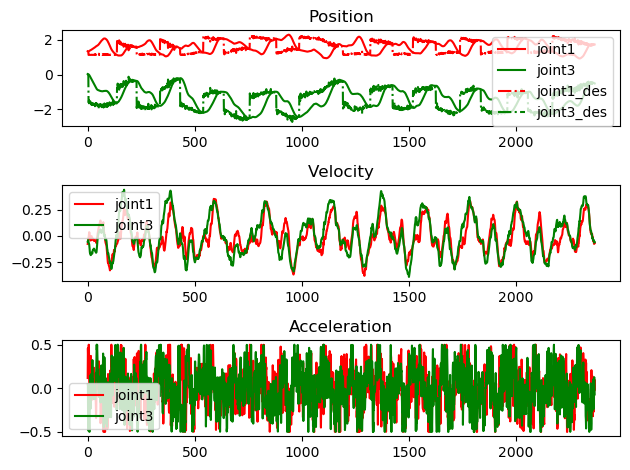

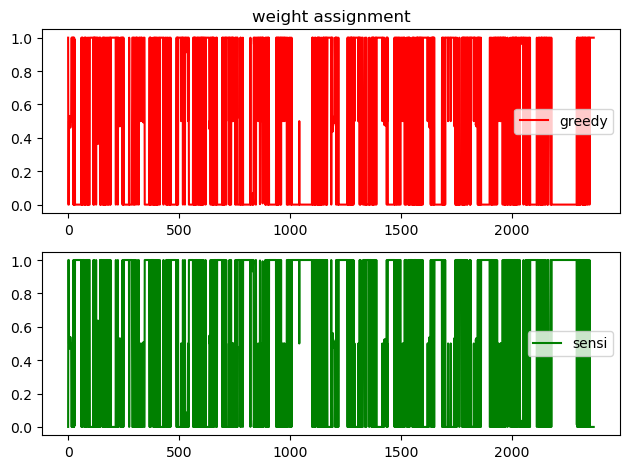

In [6]:

import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from pytransform3d.urdf import UrdfTransformManager
from pytransform3d.transformations import transform_from_pq

%matplotlib inline

with open('FrankaPM10.80.LEFT0.40.pkl', 'rb') as f:
    traj_log = pickle.load(f)

plt.figure()
position = np.matrix(traj_log['position'])
vel = np.matrix(traj_log['velocity'])
acc = np.matrix(traj_log['acc'])
des = np.matrix(traj_log['des'])

axs = [plt.subplot(3,1,i+1) for i in range(3)]
if(len(axs) >= 3):
    axs[0].set_title('Position')
    axs[1].set_title('Velocity')
    axs[2].set_title('Acceleration')
    axs[0].plot(position[:,0], 'r', label='joint1')
    axs[0].plot(position[:,2], 'g',label='joint3')
    axs[0].plot(des[:,0], 'r-.', label='joint1_des')
    axs[0].plot(des[:,2],'g-.', label='joint3_des')
    axs[0].legend()
    axs[1].plot(vel[:,0], 'r',label='joint1')
    axs[1].plot(vel[:,2], 'g', label='joint3')
    axs[1].legend()
    axs[2].plot(acc[:,0], 'r',label='joint1')
    axs[2].plot(acc[:,2], 'g', label='joint3')
    axs[2].legend()
plt.tight_layout()              

weights = np.matrix(traj_log['weights'])
plt.figure()
axs = [plt.subplot(2,1,i+1) for i in range(2)]
axs[0].set_title('weight assignment')
axs[0].plot(weights[:,0], 'r', label='greedy')
axs[0].legend() 
axs[1].plot(weights[:,1], 'g', label='sensi')
axs[1].legend() 
plt.tight_layout()   




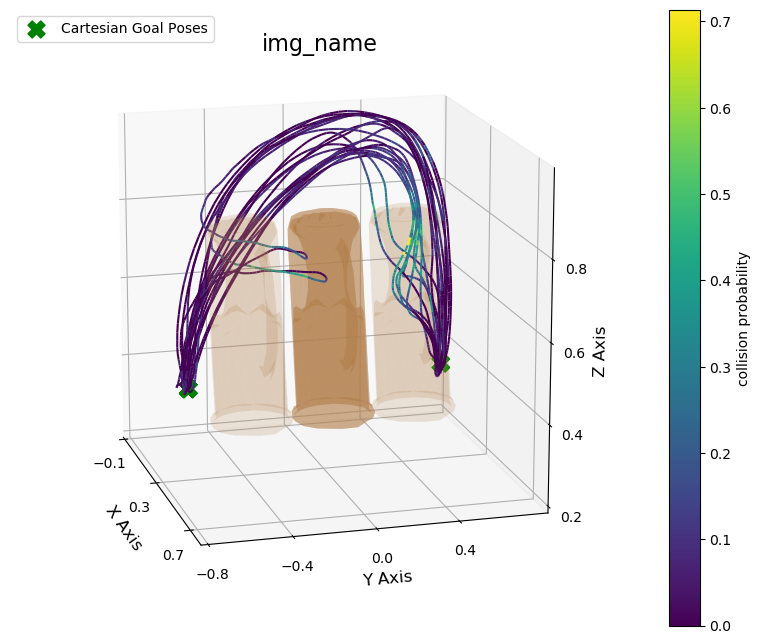

In [7]:
trajs = np.matrix(traj_log['ee_pos'])
cart_goal_poses = np.matrix(traj_log['cart_goal_pos'])
collisions = np.matrix(traj_log['collision']) # shape 为 1 * N
# 创建一个新的图像，并指定图像尺寸
fig = plt.figure(figsize=(10, 8))
# 创建一个3d的坐标系
ax = fig.add_subplot(111, projection='3d')
# 提取x,y,z轴的数据
x = trajs[:,0].flatten().tolist()[0]
y = trajs[:,1].flatten().tolist()[0]
z = trajs[:,2].flatten().tolist()[0]
coll = np.array(collisions.tolist()[0])

# 创建一个集合来保存线段
points = np.array([x, y, z]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# 基于 'c' 值创建一个色彩映射
norm = plt.Normalize(coll.min(), coll.max())
lc = Line3DCollection(segments, cmap='viridis', norm=norm)
# 设置每一段的色彩
lc.set_array(coll)
# 在3D绘图中添加线段集合
ax.add_collection(lc)
# 添加颜色条
cbar = plt.colorbar(lc)
cbar.set_label('collision probability')


# 提取目标点位的X, Y, Z坐标
x_goals = cart_goal_poses[:, 0].A1  # 将矩阵第一列转换为一维数组
y_goals = cart_goal_poses[:, 1].A1  # 将矩阵第二列转换为一维数组
z_goals = cart_goal_poses[:, 2].A1  # 将矩阵第三列转换为一维数组

# 绘制所有目标点位并指定星型标记
ax.scatter(x_goals, y_goals, z_goals, color='green', s=150, marker='X', label='Cartesian Goal Poses')
# 增加网格线
# ax.grid(True)

# ---- 设置三维柱状物 ----
# 给定的四元数和位置
q_mug_w = np.array([0.33402004837989807, 0.27801668643951416, 0.6680400967597961, -0.604036271572113])
p_mug_w = np.array([0.4000000059604645, 0.6000000238418579, 0])
pq = np.hstack((p_mug_w, q_mug_w))  # Position and unit quaternion for no rotation
T_mug_w = transform_from_pq(pq)
# 创建从世界坐标系到坐标系c的旋转矩阵
R_w_R = np.array([[1, 0, 0], 
                    [0, 0, -1], 
                    [0, 1, 0]])
# 创建从世界坐标系到robot的变换矩阵
T_w_R = np.eye(4)
T_w_R[:3, :3] = R_w_R
T_mug_R = np.dot(T_w_R, T_mug_w)
# 创建变换管理器的实例
tm = UrdfTransformManager()
# 从文件中加载 URDF 模型
with open("/home/zm/MotionPolicyNetworks/storm_ws/storm/content/assets/urdf/mug/movable_collision_test.urdf", 
          'r') as urdf_file:
    urdf_string = urdf_file.read()
tm.load_urdf(urdf_string, 
        mesh_path='/home/zm/MotionPolicyNetworks/storm_ws/storm/content/assets/urdf/mug/')
# 添加 base 框架的坐标轴
ax = tm.plot_frames_in("base", ax=ax, s=0.0, show_name=False)
# 设置多个 mug 的位置和透明度
task_leftright = True
if task_leftright:
    coll_dt_scale = 0.015 # left and right 0.02测试一次
    coll_movebound_leftright = [-0.40,0.40] # 左右实验的位置边界 [-0.4,0.4]测试一次
    goal_list = [ # 两个目标点位置
        [0.25,0.40,  0.65],
        [0.20,0.40, -0.65]]
else:
    coll_dt_scale = 0.015 # up and down
    coll_movebound_updown = [0.40,0.80] # 上下实验的位置边界
    goal_list = [ # 两个目标点位置
        [0.20,0.35,  0.65],
        [0.20,0.35, -0.65]]
init_coll_pos = [0.40,0.60,-0.20]

if task_leftright:
    poses = [
        np.array([ init_coll_pos[0], coll_movebound_leftright[0],  init_coll_pos[1] ]),
        np.array([  init_coll_pos[0],  
                    1/2*(coll_movebound_leftright[0] + coll_movebound_leftright[1]),
                    init_coll_pos[1] ]),
        np.array([ init_coll_pos[0], coll_movebound_leftright[1],  init_coll_pos[1] ])
    ]
else:
    poses = [
        np.array([ init_coll_pos[0], -init_coll_pos[-1],  coll_movebound_updown[0], ]),
        np.array([ init_coll_pos[0], -init_coll_pos[-1], 
                    1/2*(coll_movebound_updown[0] + coll_movebound_updown[1]) ]),
        np.array([ init_coll_pos[0], -init_coll_pos[-1],  coll_movebound_updown[1] ])
    ]
alphas = [0.1, 0.4, 0.1]  # 设置透明度
for pos, alpha in zip(poses, alphas):
    T_mug_R[:3, -1] = pos
    tm.add_transform("mug", "base", T_mug_R)
    tm.plot_visuals("base", ax=ax, convex_hull_of_mesh=False, alpha=alpha)

# 设置绘图范围
ax.set_xlim3d(-0.1, 0.8)
ax.set_ylim3d(-0.8, 0.8)
ax.set_zlim3d( 0.2, 1.0)

ax.set_xticks(np.arange(-0.1, 0.8, 0.4))  # 设置x轴标注的步长为1
ax.set_yticks(np.arange(-0.8, 0.8, 0.4))  # 设置y轴标注的步长为0.2
ax.set_zticks(np.arange( 0.2, 1.0, 0.2))  # 设置y轴标注的步长为0.2

# 设置轴标签
ax.set_xlabel('X Axis', fontsize=12)
ax.set_ylabel('Y Axis', fontsize=12)
ax.set_zlabel('Z Axis', fontsize=12)
# 设置标题
ax.set_title('img_name', fontsize=16)
# 显示图例，并指定图例字体大小
ax.legend(loc='upper left', fontsize=10)
# 设置背景色
ax.set_facecolor('white')
ax.view_init(elev=15.682, azim=-15.58)

plt.show()



In [8]:
import pickle
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import plotly.graph_objs as go
from plotly.subplots import make_subplots



from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from pytransform3d.urdf import UrdfTransformManager
from pytransform3d.transformations import transform_from_pq




# Ensure that matplotlib is using the Tkinter backend for interactive plots
matplotlib.use('tkagg')

def plot_trajectory(color_dict, opacity=1.0, frame = 15,  window_size = 2, joint_1 = 0, joint_2 = 2):
    with open('FrankaPM10.80.LEFT0.40.pkl', 'rb') as f:
        traj_log = pickle.load(f)

    position = np.array(np.matrix(traj_log['position']))
    vel =      np.array(np.matrix(traj_log['velocity']))
    acc =      np.array(np.matrix(traj_log['acc']))
    des =      np.array(np.matrix(traj_log['des']))
    weights =  np.array(np.matrix(traj_log['weights']))
    thresh_indexs = np.matrix(traj_log['thresh_index'])  # shape is i * M

    # Create subplots
    fig = make_subplots(rows=3, cols=1)

    # joint_1 = 0
    # joint_2 = 2
    thresh_index = thresh_indexs[0, frame]
    pre_index = thresh_indexs[0, frame - window_size]  # Use current frame minus window size for the sliding window


    # Adjusting line styles and markers
    line_options = dict(width=2.5) # 设定统一的线宽为2
    
    # Position Traces
    fig.add_trace(go.Scatter(y=position[pre_index:thresh_index, joint_1], mode='lines',
                            line=dict(color=color_dict[0], **line_options),
                            legendgroup = '1',
                            name='joint_1'), row=1, col=1,)
    fig.add_trace(go.Scatter(y=position[pre_index:thresh_index, joint_2], mode='lines',
                            line=dict(color=color_dict[1], **line_options), opacity=opacity,
                            legendgroup = '1',
                            name='joint_2'), row=1, col=1)

    # Desigreen position Traces with dashed line
    fig.add_trace(go.Scatter(y=des[pre_index:thresh_index, joint_1], mode='lines',
                            line=dict(color=color_dict[0], dash='dashdot', **line_options),
                            legendgroup = '1',
                            name='joint_1_des'), row=1, col=1)
    fig.add_trace(go.Scatter(y=des[pre_index:thresh_index, joint_2], mode='lines',
                            line=dict(color=color_dict[1], dash='dashdot', **line_options), opacity=opacity,
                            legendgroup = '1',
                            name='joint_2_des'), row=1, col=1)

    # Velocity Traces
    fig.add_trace(go.Scatter(y=vel[pre_index:thresh_index, joint_1], mode='lines',
                            line=dict(color=color_dict[0], **line_options),
                            legendgroup = '2',
                            name='v_joint_1'), row=2, col=1)
    fig.add_trace(go.Scatter(y=vel[pre_index:thresh_index, joint_2], mode='lines',
                            line=dict(color=color_dict[1], **line_options),opacity=opacity,
                            legendgroup = '2',
                            name='v_joint_2'), row=2, col=1)

    # Weight Traces
    fig.add_trace(go.Scatter(y=weights[pre_index:thresh_index, 0], mode='lines',
                            line=dict(color=color_dict[0], **line_options),
                            legendgroup = '3',
                            name='greedy_w'), row=3, col=1)
    fig.add_trace(go.Scatter(y=weights[pre_index:thresh_index, 1], mode='lines',
                            line=dict(color=color_dict[1], **line_options ),opacity=opacity,
                            legendgroup = '3',
                            name='sensi_w'), row=3, col=1)


    # 使用 update_yaxes 方法更新 Y 轴标题，将标题移到左侧，并调整间距
    yaxis_titles = ["Position", "Velocity", "Weights"]
    for i, title in enumerate(yaxis_titles, start=1):
        fig.update_yaxes(title_text=title, row=i, col=1, title_standoff=1)  # 调整间距


    # Set X-axis title only for the bottom plot
    fig.update_xaxes(title_text="", row=1, col=1, showticklabels=False)  # Hide X-axis tick labels for the first row
    fig.update_xaxes(title_text="", row=2, col=1, showticklabels=False)  # Hide X-axis tick labels for the second row
    fig.update_xaxes(title_text="Time", row=3, col=1)  # Only bottom subplot shows the X-axis title 'Time'


    # Adjusting layout
    layout_options = dict(title_font=dict(size=16, color='black'), font=dict(size=16, color='black'))

    # Adjusting layout
    fig.update_layout(height=800, showlegend=True, 
                    legend_tracegroupgap = 180,
                    margin=dict(l=100, r=100, t=100, b=100),  # Adjust the margin to ensure titles fit
                    **layout_options
                    )
    # Show figure
    fig.show()




In [9]:

plot_trajectory(['orange','navy'], opacity=1.0, frame = 11,  window_size = 4, joint_1 = 1, joint_2 = 2)

In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_trajectory(color_dict, opacity=1.0, frame=15, window_size=2, joint_1=0, joint_2=2):
    with open('FrankaPM10.80.LEFT0.40.pkl', 'rb') as f:
        traj_log = pickle.load(f)

    position = np.array(np.matrix(traj_log['position']))
    vel = np.array(np.matrix(traj_log['velocity']))
    acc = np.array(np.matrix(traj_log['acc']))
    des = np.array(np.matrix(traj_log['des']))
    weights = np.array(np.matrix(traj_log['weights']))
    thresh_indexs = np.matrix(traj_log['thresh_index'])

    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

    thresh_index = thresh_indexs[0, frame]
    pre_index = thresh_indexs[0, frame - window_size]

    line_options = {'linewidth': 2}

    # Position Traces
    axs[0].plot(position[pre_index:thresh_index, joint_1], color=color_dict[0], label='joint_1', **line_options)
    axs[0].plot(position[pre_index:thresh_index, joint_2], color=color_dict[1], label='joint_2', alpha=opacity, **line_options)
    axs[0].plot(des[pre_index:thresh_index, joint_1], color=color_dict[0], linestyle='dashdot', label='joint_1_des', **line_options)
    axs[0].plot(des[pre_index:thresh_index, joint_2], color=color_dict[1], linestyle='dashdot', label='joint_2_des', alpha=opacity, **line_options)
    axs[0].set_ylabel('Position', fontsize=12)  # Adjust font size of y-axis label
    axs[0].grid(True)

    # Velocity Traces
    axs[1].plot(vel[pre_index:thresh_index, joint_1], color=color_dict[0], label='v_joint_1', **line_options)
    axs[1].plot(vel[pre_index:thresh_index, joint_2], color=color_dict[1], label='v_joint_2', alpha=opacity, **line_options)
    axs[1].set_ylabel('Velocity', fontsize=12)  # Adjust font size of y-axis label
    axs[1].grid(True)

    # Weight Traces
    axs[2].plot(weights[pre_index:thresh_index, 0], color=color_dict[0], label='greedy_w', **line_options)
    axs[2].plot(weights[pre_index:thresh_index, 1], color=color_dict[1], label='sensi_w', alpha=opacity, **line_options)
    axs[2].set_ylabel('Weights', fontsize=12)  # Adjust font size of y-axis label
    axs[2].set_xlabel('Time', fontsize=12)  # Adjust font size of x-axis label
    axs[2].grid(True)

    for ax in axs:
        ax.legend(loc='upper left')

    plt.suptitle('Trajectory Plot', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# 定义绘图颜色的常量字典，方便修改与引用
COLOR_DICT = {0: 'blue', 1: 'orange'}

def plot_trajectory(opacity=1.0, frame=15, window_size=2, joint_1=0, joint_2=2):
    # 尝试打开Pickle文件并处理可能发生的异常
    try:
        with open('FrankaPM10.80.LEFT0.40.pkl', 'rb') as f:
            traj_log = pickle.load(f)
    except FileNotFoundError:
        print("指定的Pickle文件未找到。")
        return
    except Exception as e:
        print(f"加载数据时发生错误：{e}")
        return

    # 将日志中的数据构造为numpy数组
    position = np.asarray(traj_log['position'])
    velocity = np.asarray(traj_log['velocity'])
    acceleration = np.asarray(traj_log['acc']) # 此变量未在图中使用
    desired = np.asarray(traj_log['des'])
    weights = np.asarray(traj_log['weights'])
    thresh_indices = np.asarray(traj_log['thresh_index'])

    # 设置子图大小和布局
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

    # 根据给定帧数和窗口大小计算索引
    thresh_index = thresh_indices[frame]
    pre_index = thresh_indices[frame - window_size]

    # 线条样式选项
    line_options = {'linewidth': 2}

    # 绘制关节的位置轨迹
    axs[0].plot(position[pre_index:thresh_index, joint_1], color=COLOR_DICT[0], label='Joint 1', **line_options)
    axs[0].plot(position[pre_index:thresh_index, joint_2], color=COLOR_DICT[1], label='Joint 2', alpha=opacity, **line_options)
    axs[0].plot(desired[pre_index:thresh_index, joint_1], color=COLOR_DICT[0], linestyle='dashdot', label='Joint 1 Desired', **line_options)
    axs[0].plot(desired[pre_index:thresh_index, joint_2], color=COLOR_DICT[1], linestyle='dashdot', label='Joint 2 Desired', alpha=opacity, **line_options)
    axs[0].set_ylabel('Position')
    axs[0].grid(True)

    # 绘制关节的速度轨迹
    axs[1].plot(velocity[pre_index:thresh_index, joint_1], color=COLOR_DICT[0], label='V_Joint 1', **line_options)
    axs[1].plot(velocity[pre_index:thresh_index, joint_2], color=COLOR_DICT[1], label='V_Joint 2', alpha=opacity, **line_options)
    axs[1].set_ylabel('Velocity')
    axs[1].grid(True)

    # 绘制权重轨迹
    axs[2].plot(weights[pre_index:thresh_index, 0], color=COLOR_DICT[0], label='Greedy Weight', **line_options)
    axs[2].plot(weights[pre_index:thresh_index, 1], color=COLOR_DICT[1], label='Sensitivity Weight', alpha=opacity, **line_options)
    axs[2].set_ylabel('Weights')
    axs[2].set_xlabel('Time')
    axs[2].grid(True)

    # 为所有子图添加图例
    for ax in axs:
        ax.legend(loc='upper left')

    # 设置图像标题并调整布局
    plt.suptitle('Trajectory Analysis', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 调用函数
plot_trajectory()

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_trajectory(color_dict, opacity=1.0, frame=15, window_size=2, joint_1=0, joint_2=2):
    with open('FrankaPM10.80.LEFT0.40.pkl', 'rb') as f:
        traj_log = pickle.load(f)

    position = np.array(np.matrix(traj_log['position']))
    vel = np.array(np.matrix(traj_log['velocity']))
    acc = np.array(np.matrix(traj_log['acc']))
    des = np.array(np.matrix(traj_log['des']))
    weights = np.array(np.matrix(traj_log['weights']))
    thresh_indexs = np.matrix(traj_log['thresh_index'])    

    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

    thresh_index = thresh_indexs[0, frame]
    pre_index = thresh_indexs[0, frame - window_size]

    line_options = {'linewidth': 1.5}

    # Position Traces
    axs[0].plot(position[pre_index:thresh_index, joint_1], color=color_dict[0], label='joint_1', **line_options)
    axs[0].plot(position[pre_index:thresh_index, joint_2], color=color_dict[1], label='joint_2', alpha=opacity, **line_options)
    axs[0].plot(des[pre_index:thresh_index, joint_1], color=color_dict[0], linestyle='dashdot', label='joint_1_des', **line_options)
    axs[0].plot(des[pre_index:thresh_index, joint_2], color=color_dict[1], linestyle='dashdot', label='joint_2_des', alpha=opacity, **line_options)
    axs[0].set_ylabel('Position', fontsize=12, labelpad=10)  # Adjust font size and labelpad
    axs[0].grid(True)

    # Velocity Traces
    axs[1].plot(vel[pre_index:thresh_index, joint_1], color=color_dict[0], label='v_joint_1', **line_options)
    axs[1].plot(vel[pre_index:thresh_index, joint_2], color=color_dict[1], label='v_joint_2', alpha=opacity, **line_options)
    axs[1].set_ylabel('Velocity', fontsize=12, labelpad=0)  # Adjust font size and labelpad
    axs[1].grid(True)

    # Weight Traces
    axs[2].plot(weights[pre_index:thresh_index, 0], color=color_dict[0], label='greedy_w', **line_options)
    axs[2].plot(weights[pre_index:thresh_index, 1], color=color_dict[1], label='sensi_w', alpha=opacity, **line_options)
    axs[2].set_ylabel('Weights', fontsize=12, labelpad=10)  # Adjust font size and labelpad
    axs[2].set_xlabel('Time', fontsize=12)
    axs[2].grid(True)

    for ax in axs:
        ax.legend(loc='upper left')

    plt.suptitle('Trajectory Plot', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example color dictionary
color_dict = {0: 'blue', 1: 'green'}

# Example usage
plot_trajectory(color_dict)


In [13]:
# Example color dictionary
color_dict = {0: 'red', 1: 'green'}

# Example usage
plot_trajectory(color_dict,opacity=1.0, frame = 11,  window_size = 4, joint_1 = 0, joint_2 = 2)
plot_trajectory(color_dict, frame = 11,  window_size = 3)
plot_trajectory(color_dict)